## **Programming for Data Analysis Assignment 2**

***

## **Table of Contents**

## **Introduction**

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from sklearn.impute import SimpleImputer
import random
from plotly.offline import iplot
from plotnine import ggplot, aes, geom_line, geom_bar, geom_point, labs, coord_flip, theme_xkcd, geom_smooth

### Polar Ice

In [2]:
sea_ice = pd.read_csv('CSV Files\seaice.csv')

In [3]:
# We only take data from the northern hemisphere
northern = sea_ice[sea_ice.iloc[:,6]=='north']

In [4]:
# Save the list of the years
years_list = list(northern['Year'].value_counts().index)
years_list = sorted(years_list)

In [5]:
import warnings
warnings.simplefilter(action='ignore')
# Calcule monthly average of sea ice extent
def by_months(northern):    
    n_months = 3 + ((2019-1979) * 12) + 5 
    sea_ice_monthly = pd.DataFrame(columns=['Year', 'Month', 'Extent'], index=range(n_months))
    i = 0
    for year in years_list:
        
        if year == 1978:
            months_list = range(10,13)
        elif year == 2019:
            months_list = range(1,6)
        else:
            months_list = range(1,13)

        for month in months_list:
            subset = northern[northern['Year']==year][northern.iloc[:,1]==month]
            monthly_mean = np.mean(subset.iloc[:,3])
            sea_ice_monthly.iloc[i] = [year, month, monthly_mean]
            i += 1

    return sea_ice_monthly

sea_ice_clean = by_months(northern)

In [6]:
sea_ice_clean.head()

,Year,Month,Extent
0,1978,10,10.402667
1,1978,11,11.645133
2,1978,12,13.667063
3,1979,1,15.414
4,1979,2,16.175286


In [7]:
# Sort the dataset per month and year
sea_ice_clean = sea_ice_clean.sort_values(['Month', 'Year'])
sea_ice_clean = sea_ice_clean.reset_index().drop(['index'], axis=1)
sea_ice_clean.head()

,Year,Month,Extent
0,1979,1,15.414
1,1980,1,14.861875
2,1981,1,14.909688
3,1982,1,15.176733
4,1983,1,14.942438


In [8]:
mean_years = []
std_dict = {}
for m in range(1,13):
  #Calcule mu and std values
  mu = sea_ice_clean[sea_ice_clean.Month == m]['Extent'].mean()
  std = sea_ice_clean[sea_ice_clean.Month == m]['Extent'].std()
  #Save mu and std values
  mean_years.append(mu)
  std_dict[m] = std

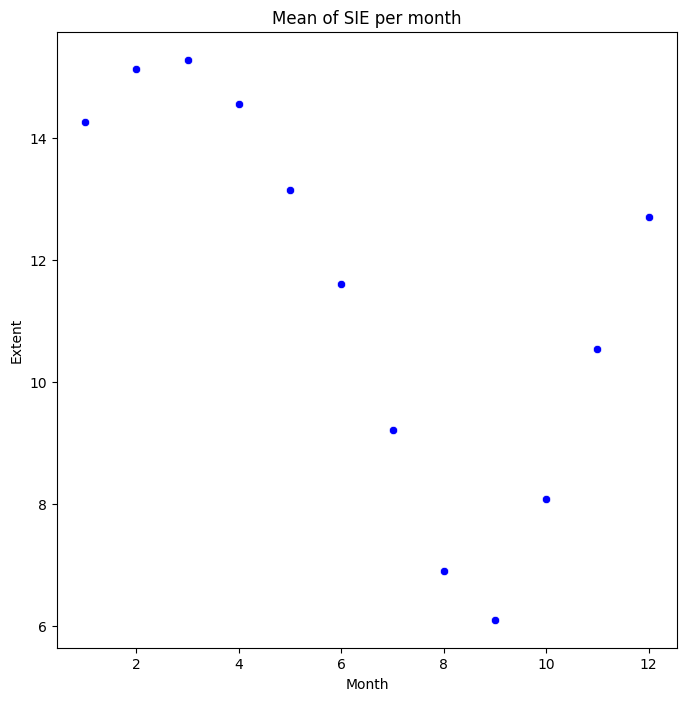

In [9]:
df_mean_years = pd.DataFrame(mean_years)
df_mean_years['Month'] = range(1, 13)
df_mean_years.columns = ['Extent', 'Month']
plt.figure(figsize=(8, 8))
sns.scatterplot(x='Month', y='Extent', data=df_mean_years,  color='blue', sizes=20).set(title='Mean of SIE per month')
plt.show()

In [10]:
#Compute Sea Ice Extent anomalies
def anomaliesSIE(sea_ice):
  #Calcule mean by months from 1981-2010
  df_30y = sea_ice.query('1981 <= Year <= 2010')
  df_30y = df_30y.reset_index().drop(['index'], axis=1)
  mean_30y = []
  for m in range(1,13):
    mu = sea_ice[sea_ice.Month == m]['Extent'].mean()
    mean_30y.append(mu)

  #Compute SIE anomalies
  anomalies_list = []
  for s in range(0, len(sea_ice)):
    mean_30y_index = sea_ice.loc[s, 'Month']-1
    #Calcule anomalies
    anomalies_SIE = sea_ice.loc[s, 'Extent'] - mean_30y[mean_30y_index]
    anomalies_SIE = anomalies_SIE/mean_30y[mean_30y_index]*100
    #Save anomalies
    anomalies_list.append(anomalies_SIE)
  sea_ice['AnomaliesSIE'] = anomalies_list
  return sea_ice, mean_30y

df_SIE, mean_30y = anomaliesSIE(sea_ice_clean)
df_SIE.head()

,Year,Month,Extent,AnomaliesSIE
0,1979,1,15.414,8.034332
1,1980,1,14.861875,4.164574
2,1981,1,14.909688,4.499684
3,1982,1,15.176733,6.371367
4,1983,1,14.942438,4.729224


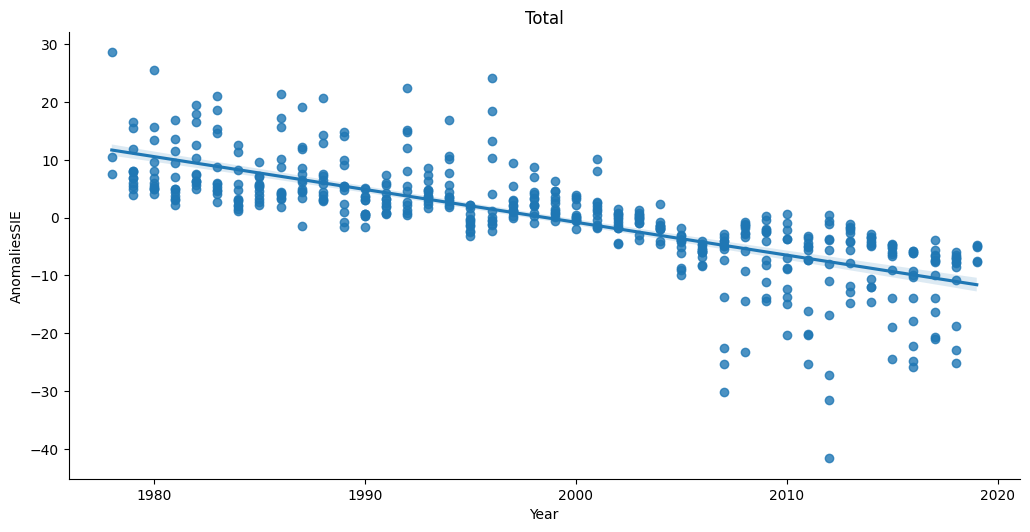

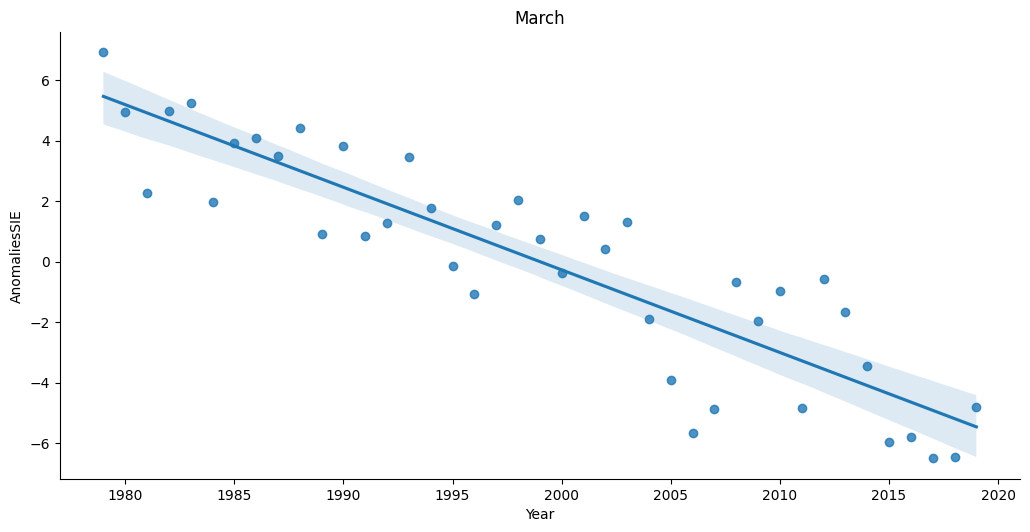

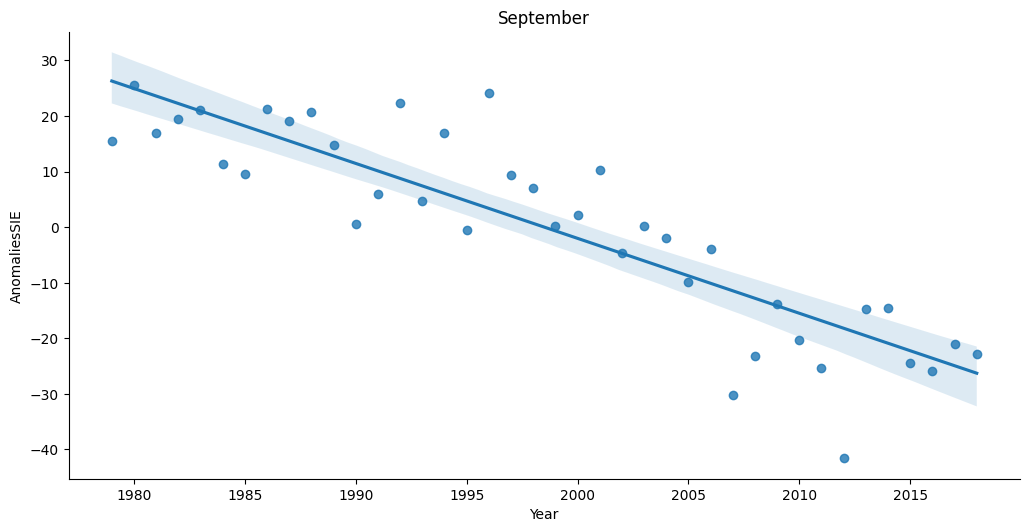

In [11]:
df_SIE['Year'] = pd.to_numeric(df_SIE['Year'])
#Total
sns.lmplot(x='Year', y='AnomaliesSIE', data=df_SIE, height=5.2, aspect=2).set(title='Total')
plt.show()
#January
sns.lmplot(x='Year', y='AnomaliesSIE', data=df_SIE[df_SIE.Month == 3], height=5.2, aspect=2).set(title='March')
plt.show()
#June
sns.lmplot(x='Year', y='AnomaliesSIE', data=df_SIE[df_SIE.Month == 9], height=5.2, aspect=2).set(title='September')
plt.show()

### Rainfall in Ireland

In [12]:
rainfall_ireland = pd.read_csv('CSV Files/rainfall_ireland.csv')

In [13]:
rainfall_ireland.head()

,Year,Month,Rainfall
0,1711,1,16.4
1,1711,2,73.1
2,1711,3,121.2
3,1711,4,85.2
4,1711,5,66.6


In [14]:
# Sort the dataset per month and year
rainfall_ireland = rainfall_ireland.sort_values(['Month', 'Year'])
rainfall_ireland = rainfall_ireland.reset_index().drop(['index'], axis=1)
rainfall_ireland.head()

,Year,Month,Rainfall
0,1711,1,16.4
1,1712,1,42.6
2,1713,1,97.3
3,1714,1,42.4
4,1715,1,125.8


In [15]:
mean_years = []
std_dict = {}
for m in range(1,13):
  #Calcule mu and std values
  mu = rainfall_ireland[rainfall_ireland.Month == m]['Rainfall'].mean()
  std = rainfall_ireland[rainfall_ireland.Month == m]['Rainfall'].std()
  #Save mu and std values
  mean_years.append(mu)
  std_dict[m] = std

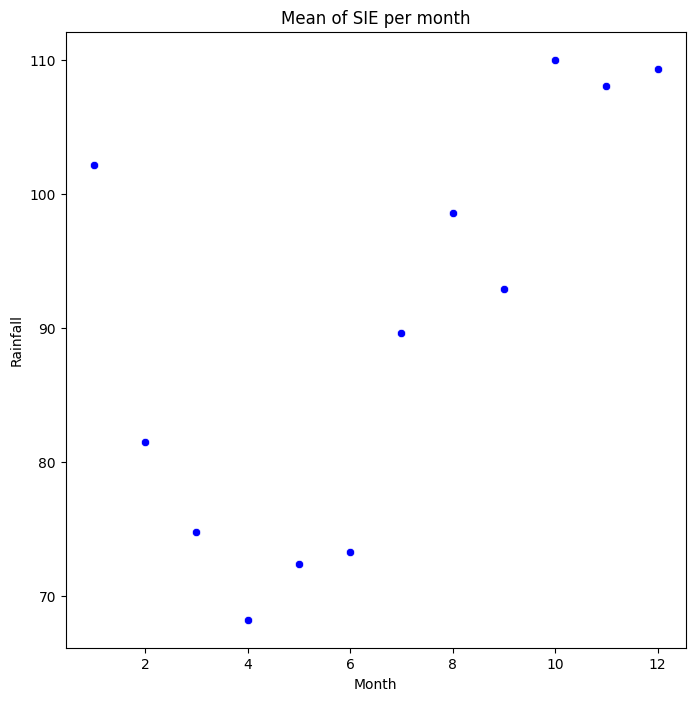

In [16]:
df_mean_years = pd.DataFrame(mean_years)
df_mean_years['Month'] = range(1, 13)
df_mean_years.columns = ['Rainfall', 'Month']
plt.figure(figsize=(8, 8))
sns.scatterplot(x='Month', y='Rainfall', data=df_mean_years,  color='blue', sizes=20).set(title='Mean of SIE per month')
plt.show()

In [17]:
#Compute Rainfall anomalies
def anomaliesSIE(rainfall_ireland):
  #Calcule mean by months from 1981-2010
  df_300y = rainfall_ireland.query('1711 <= Year <= 2016')
  df_300y = df_300y.reset_index().drop(['index'], axis=1)
  mean_300y = []
  for m in range(1,13):
    mu = rainfall_ireland[rainfall_ireland.Month == m]['Rainfall'].mean()
    mean_300y.append(mu)

  #Compute SIE anomalies
  anomalies_list = []
  for s in range(0, len(rainfall_ireland)):
    mean_300y_index = rainfall_ireland.loc[s, 'Month']-1
    #Calcule anomalies
    anomalies_SIE = rainfall_ireland.loc[s, 'Rainfall'] - mean_300y[mean_300y_index]
    anomalies_SIE = anomalies_SIE/mean_300y[mean_300y_index]*100
    #Save anomalies
    anomalies_list.append(anomalies_SIE)
  rainfall_ireland['AnomaliesSIE'] = anomalies_list
  return rainfall_ireland, mean_300y

df_SIE, mean_300y = anomaliesSIE(rainfall_ireland)
df_SIE.head()

,Year,Month,Rainfall,AnomaliesSIE
0,1711,1,16.4,-83.947182
1,1712,1,42.6,-58.301825
2,1713,1,97.3,-4.759803
3,1714,1,42.4,-58.497591
4,1715,1,125.8,23.136864


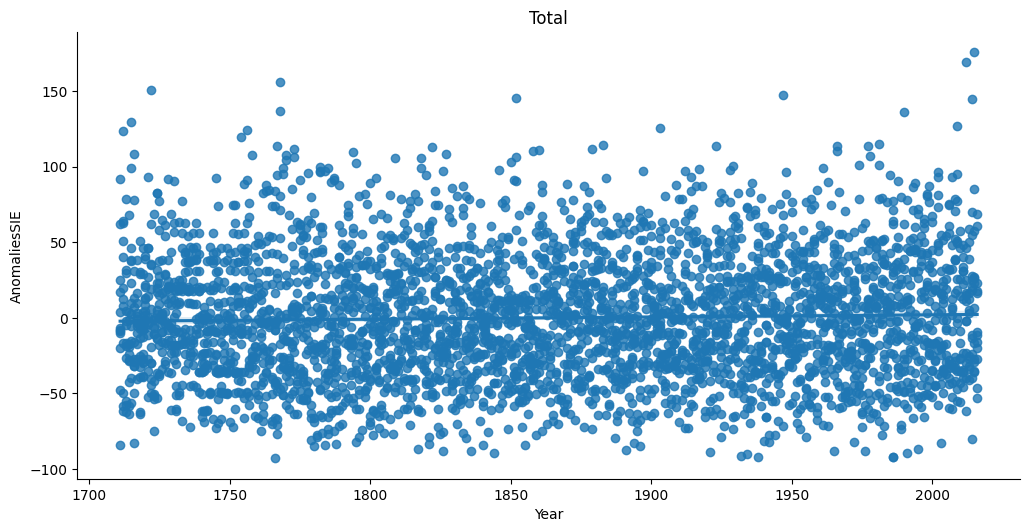

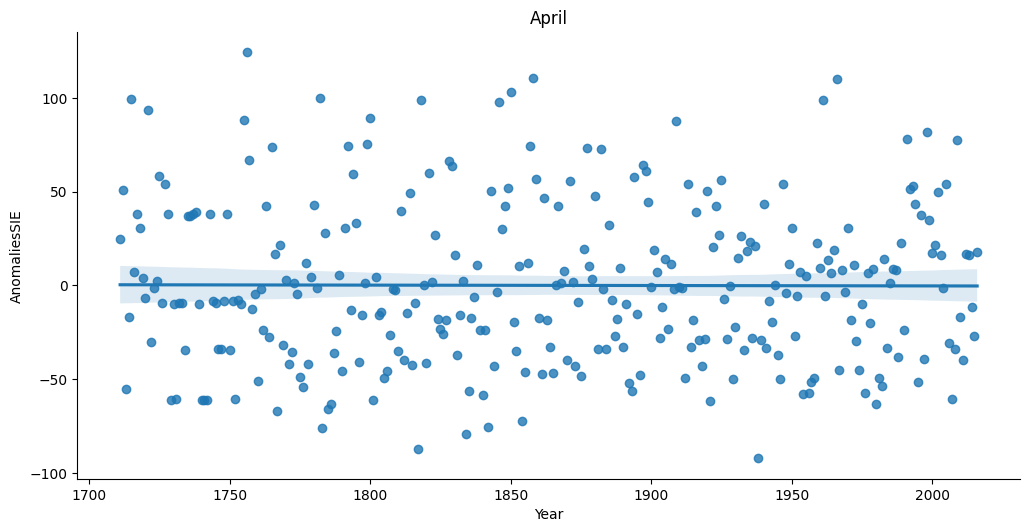

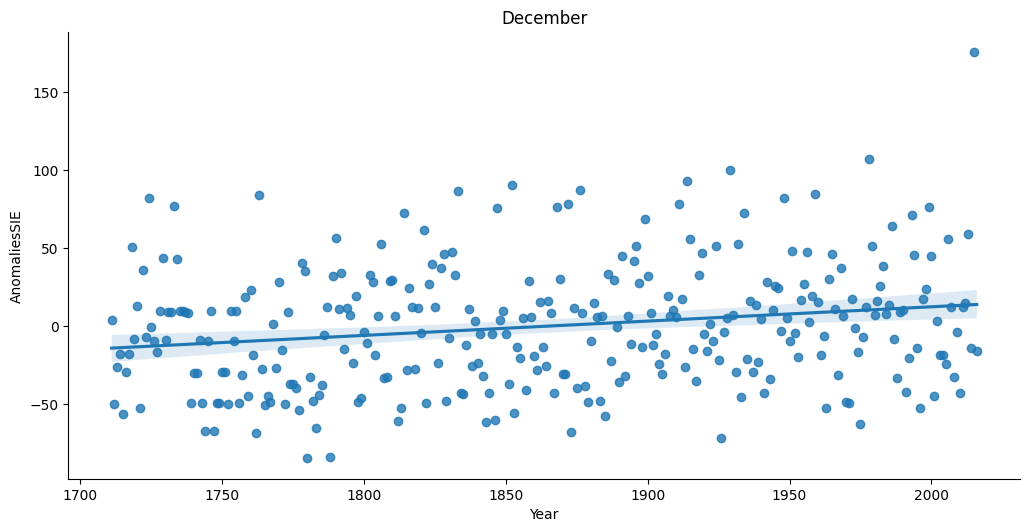

In [18]:
df_SIE['Year'] = pd.to_numeric(df_SIE['Year'])
#Total
sns.lmplot(x='Year', y='AnomaliesSIE', data=df_SIE, height=5.2, aspect=2).set(title='Total')
plt.show()
#April
sns.lmplot(x='Year', y='AnomaliesSIE', data=df_SIE[df_SIE.Month == 4], height=5.2, aspect=2).set(title='April')
plt.show()
#December
sns.lmplot(x='Year', y='AnomaliesSIE', data=df_SIE[df_SIE.Month == 12], height=5.2, aspect=2).set(title='December')
plt.show()

### Temperature and CO2

In [144]:
epica = pd.read_csv('CSV Files\Epica Temp.csv', encoding='ISO-8859-1')
ipcc = pd.read_csv('CSV Files\IPCC CO2.csv')
nature = pd.read_csv('CSV Files/Nature CO2.csv', dtype={'year': float})

In [145]:
epica = epica[['year', 'temp']]
ipcc = ipcc[['year', 'co2']]
nature = nature[['year', 'co2']]

epica.year = epica.year.round()
ipcc["year"] = pd.to_numeric(ipcc["year"])
ipcc.year = ipcc.year.round()

In [146]:
nature["year"] = pd.to_numeric(nature["year"])
nature.year = nature.year.round()
nature.to_csv("nature.csv", encoding='utf-8', index=False)

In [147]:
epica['year'] = 1950 - epica['year']
ipcc['year'] = 1950 - ipcc['year']
nature['year'] = 1950 - nature['year']

In [148]:
combined_CO2 = pd.concat([ipcc, nature])
combined_CO2.sort_values(by=['year'], ascending=True)

temp_CO2 = pd.concat([epica.dropna(), combined_CO2.dropna()], ignore_index=True)
temp_CO2.sort_values(by=['year'], ascending=True);

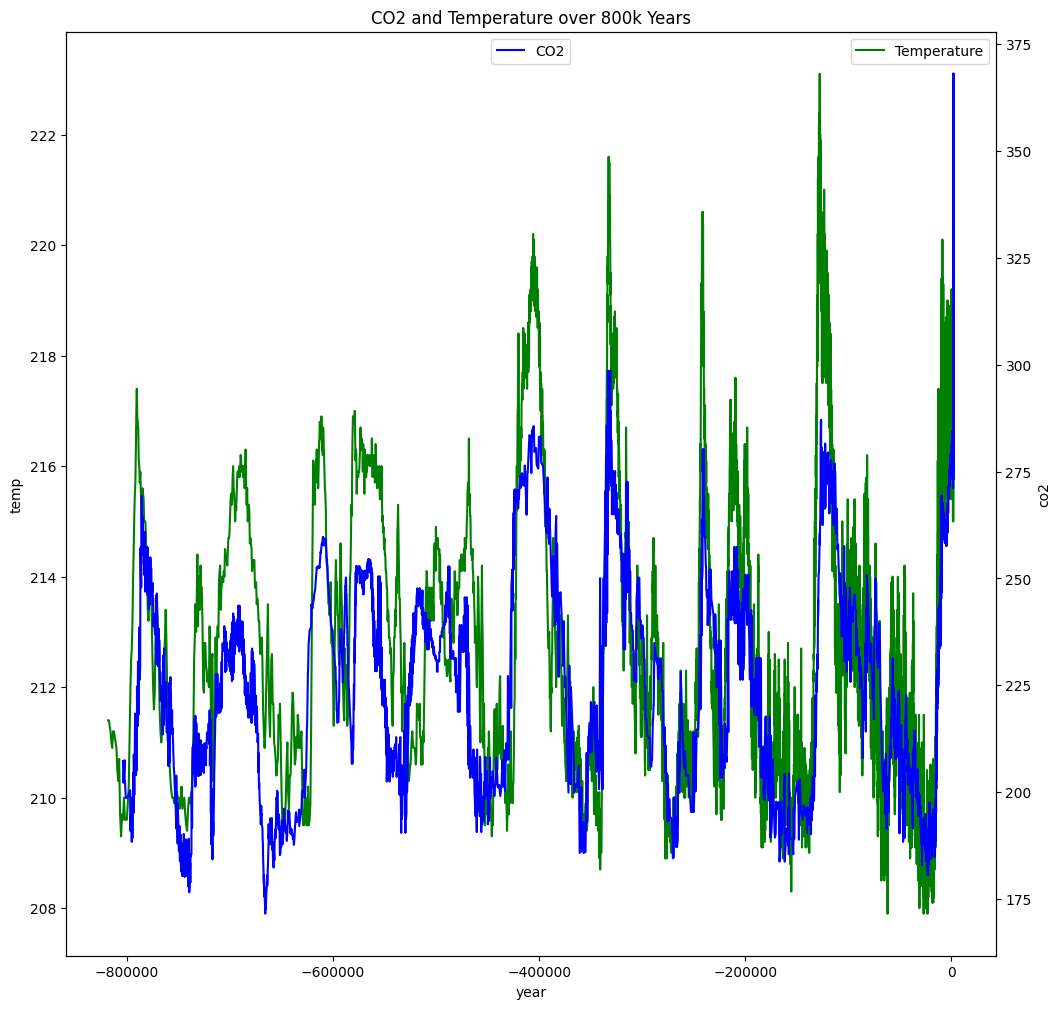

In [149]:
fig, ax = plt.subplots(figsize=(12,12))
sns.lineplot(x="year", y="temp", data=temp_CO2, color="g", label="Temperature")
ax2 = plt.twinx()
sns.lineplot(x="year", y="co2", data=temp_CO2, color="b", ax=ax2, label="CO2")
plt.title("CO2 and Temperature over 800k Years")
plt.legend(loc='upper center')

In [164]:
temp_present = pd.read_csv('CSV Files/temp 1958 to present.csv', encoding='ISO-8859-1', dtype={'year': float})
temp_present = temp_present[['year', 'temp']]
temp_present.to_csv('temp_present.csv', index=False)

'''combined_temp = pd.concat([epica, temp_present])
combined_temp.year = combined_temp.year.astype(float)
combined_temp.sort_values(by=['year'], ascending=True);'''

"combined_temp = pd.concat([epica, temp_present])\ncombined_temp.year = combined_temp.year.astype(float)\ncombined_temp.sort_values(by=['year'], ascending=True);"

In [166]:
temp_CO2_present = pd.concat([epica.dropna(), combined_CO2.dropna(), temp_present.dropna()], ignore_index=True)
temp_CO2_present.sort_values(by=['year'], ascending=True);
temp_CO2_present.to_csv('temp_CO2_present.csv', index=False)

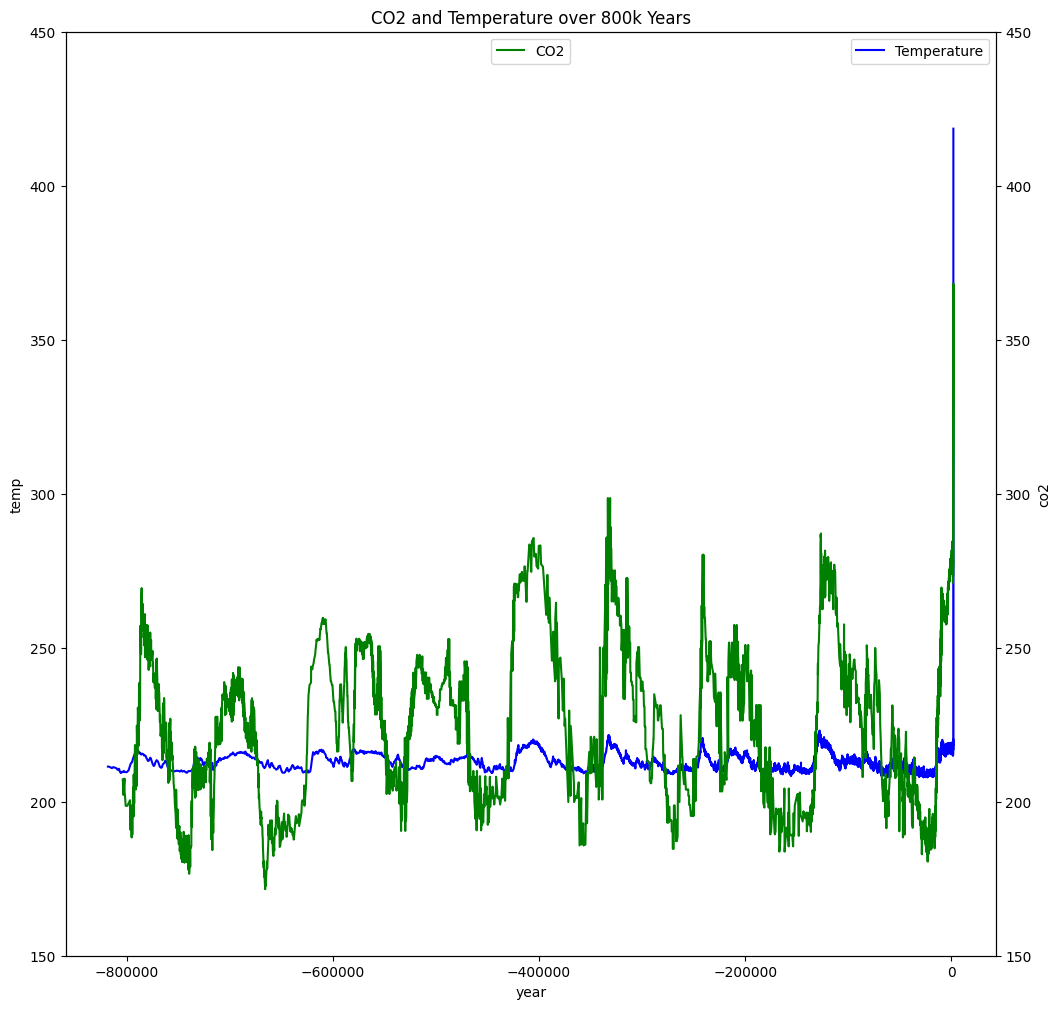

In [170]:
fig, ax1 = plt.subplots(figsize=(12,12))
ax2 = ax1.twinx()
sns.lineplot(x="year", y="temp", data=temp_CO2_present, color="b", ax=ax1, label="Temperature")
sns.lineplot(x="year", y="co2", data=temp_CO2_present, color="g", ax=ax2, label="CO2")
ax1.set_ylim(150,450)
ax2.set_ylim(150,450)
plt.title("CO2 and Temperature over 800k Years")
plt.legend(loc='upper center')